# Rotated Coordinates

Within the realm of TSMP often rotated geographical coordinates are used, so an an example is given here to explain how to convert between regular geographic coordinates and rotated geographic coordinates, as well as to provide some understanding what rotated coordinates are in general. 

## Preparation

Before we start, lets prepare some technical things.   
First, we have to make `SLOTH` available to import by Python. If you already have added `SLOTH` to your `PYHTONPATH`, below step is not needed.

In [1]:
import os
import sys

cwd = os.getcwd()
sloth_path = f"{cwd}/../"
sys.path.append(sloth_path)

Second, we need to import all libraries needed in the following example.

In [2]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

import cartopy
import sloth.coordTrafo
import sloth.slothHelper
from cartopy.mpl.ticker import LatitudeFormatter, LatitudeLocator, LongitudeFormatter

%matplotlib inline

Third, we will plot some georeferenced data with different projections. To keep the src-code clean and easy to read, we define a function below, simply to avoid rewriting the code inside the function over and over again, if we need some repetitive plots.  

In [3]:
def plot_globalMapWithData(fig, map_projection, coord_projection,
                           title, position=111, alpha=1,
                           lon2D=None, lat2D=None, data=None):
    ax = fig.add_subplot(position, projection=map_projection)
    ax.set_global()
    gl = ax.gridlines(crs=coord_projection)
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
    ax.coastlines()
    equator_X = np.arange(-180, 180)
    equator_Y = np.zeros_like(equator_X)
    ax.plot(equator_X, equator_Y, color="blue", linewidth=2, transform=coord_projection)
    ax.set_title(f"{title}")
    if data is not None:
        colors = [(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]
        n_bin = 2
        cmap = mpl.colors.LinearSegmentedColormap.from_list('TmpName', 
                                                            colors, 
                                                            N=n_bin)
        ax.pcolormesh(lon2D, lat2D, data, 
                      transform=coord_projection, alpha=alpha,
                      cmap=cmap)

    return ax

## Why using rotated geographical coordinates?

Within the realm of TSMP, rotated geographical coordinates are often used. This is necessary because COSMO depends on rotated geographical coordinates for the only reason to avoid the meridian convergence.   
Meridian convergence basically describes the decreasing angle between two meridians and therefore the decreasing physical distance between the same meridians with increasing latitude. This means that if you set up a computational grid with the same degree distance between all grid points, the area covered by a grid cell will decrease with increasing latitude and its shape is will not be rectangular.    

The effect of the meridian convergence is illustrated below using the example of three squares whose edges are equidistant in degrees.

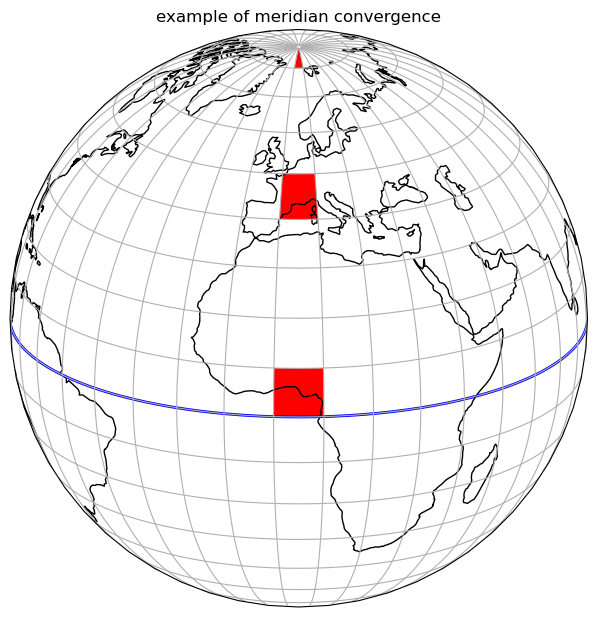

In [4]:
orthographic = cartopy.crs.Orthographic(
    central_longitude=5.0, central_latitude=20.0, globe=None
)
platecarree = cartopy.crs.PlateCarree()

fig = plt.figure(figsize=(7.5, 7.5))
ax = plot_globalMapWithData(
    fig=fig,
    map_projection=orthographic,
    coord_projection=cartopy.crs.PlateCarree(),
    title="example of meridian convergence",
    position=111,
    lon2D=None,
    lat2D=None,
    data=None,
)

ax.add_patch(
    mpatches.Rectangle( xy=[0, 0], width=10, height=10,
                       facecolor="red",
                       transform=cartopy.crs.PlateCarree(),
    )
)

ax.add_patch(
    mpatches.Rectangle( xy=[0, 40], width=10, height=10,
                       facecolor="red",
                       transform=cartopy.crs.PlateCarree(),
    )
)

ax.add_patch(
    mpatches.Rectangle(xy=[0, 80], width=10, height=10,
                       facecolor="red",
                       transform=cartopy.crs.PlateCarree(),
    )
)

Knowing that this effect is smallest near the equator, one can imagine a rotated coordinate system, moving the North Pole so that the equator passes through the centre of the desired computational domain. This does not make the meridian convergence disappear, but reduces its effect as much as possible.

An illustrative example is given below.    
The left plot shows the orbital view of the Earth with the coordinate grid lines of the regular geographic coordinate system.    
The right plot shows the orbital view of the Earth with the coordinate grid lines of a rotated geographical coordinate system, rotated so that the equator passes through the centre of Europe, the intended computational domain. 

<GeoAxesSubplot:title={'center':'grid lines of the rotated geographical coordinate system'}>

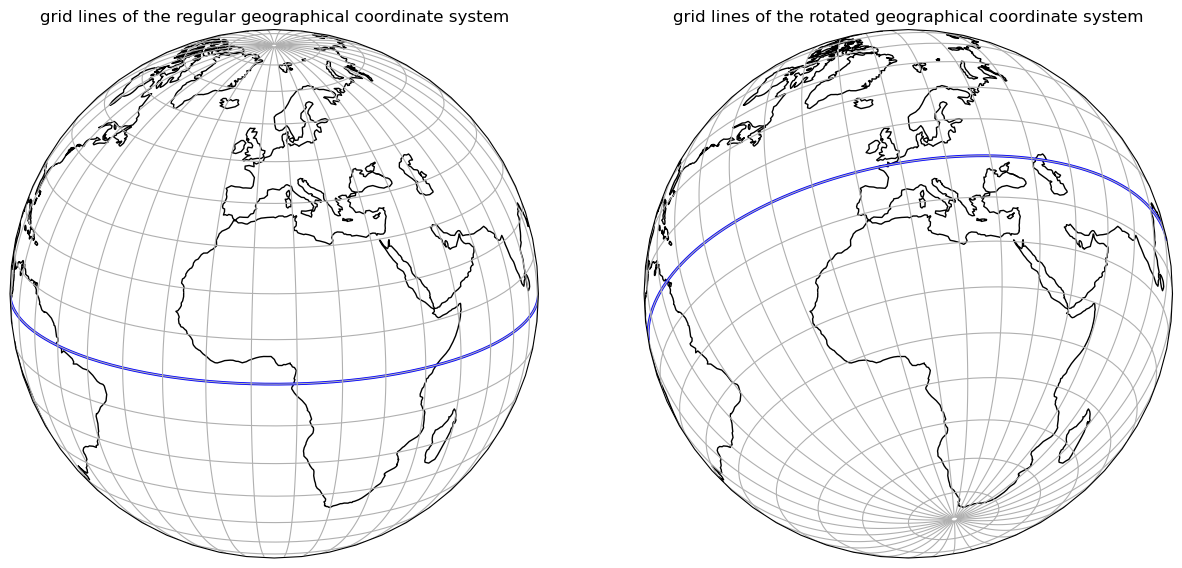

In [5]:
np_lon = -162.0
np_lat = 39.25
rotated_pole = cartopy.crs.RotatedPole(pole_latitude=np_lat, pole_longitude=np_lon)
orthographic = cartopy.crs.Orthographic(
    central_longitude=5.0, central_latitude=20.0, globe=None
)

fig = plt.figure(figsize=(15, 7.5))
plot_globalMapWithData(
    fig=fig,
    map_projection=orthographic,
    coord_projection=cartopy.crs.PlateCarree(),
    title="grid lines of the regular geographical coordinate system",
    position=121,
    lon2D=None,
    lat2D=None,
    data=None,
)

plot_globalMapWithData(
    fig=fig,
    map_projection=orthographic,
    coord_projection=rotated_pole,
    title="grid lines of the rotated geographical coordinate system",
    position=122,
    lon2D=None,
    lat2D=None,
    data=None,
)

To keep the effect of the meridian convergence small, COSMO uses rotated geographical coordinates. The exact parameters for the rotation, namely the new, rotated position of the North Pole, can be set individually in COMSO and usually depend on the intended simulation domain.    
For the sake of comparability, the CORDEX-Project has defined several [simulation domains](https://cordex.org/domains/) in rotated geographical coordinates and provides all relevant parameters. One of these domains is the `EUR-11` domain, with the North Pole rotated to `39.25°N 162.0°E`, which is often used in the realm of TSMP.   

The grid description of the CORDEX-Project in rotated geographical coordinates can be read in with `SLOTH` and transformed into regular geographic coordinates.

In [6]:
EUR11_griddes = sloth.slothHelper.get_cordexDomDef("EUR-11")
np_lat = EUR11_griddes["NPlat"]
np_lon = EUR11_griddes["NPlon"]

rlon1D = np.array(
    [
        EUR11_griddes["SWlon"] + (i * EUR11_griddes["dlon"])
        for i in range(EUR11_griddes["Nlon"])
    ]
)
rlat1D = np.array(
    [
        EUR11_griddes["SWlat"] + (i * EUR11_griddes["dlat"])
        for i in range(EUR11_griddes["Nlat"])
    ]
)
rlon2D, rlat2D = np.meshgrid(rlon1D, rlat1D)
lat2D, lon2D = sloth.coordTrafo.undo_grid_rotation(
    rlat=rlat2D, rlon=rlon2D, np_lat=np_lat, np_lon=np_lon
)

## Plot examples of rotated geographical coordinates

Below are some examples showing the `EUR-11` domain, but plotted in different projections, to familiarise you with the rotated geographical coordinates and different projections.  

<GeoAxesSubplot:title={'center':'EUR-11 in regular geographical coordinates'}>

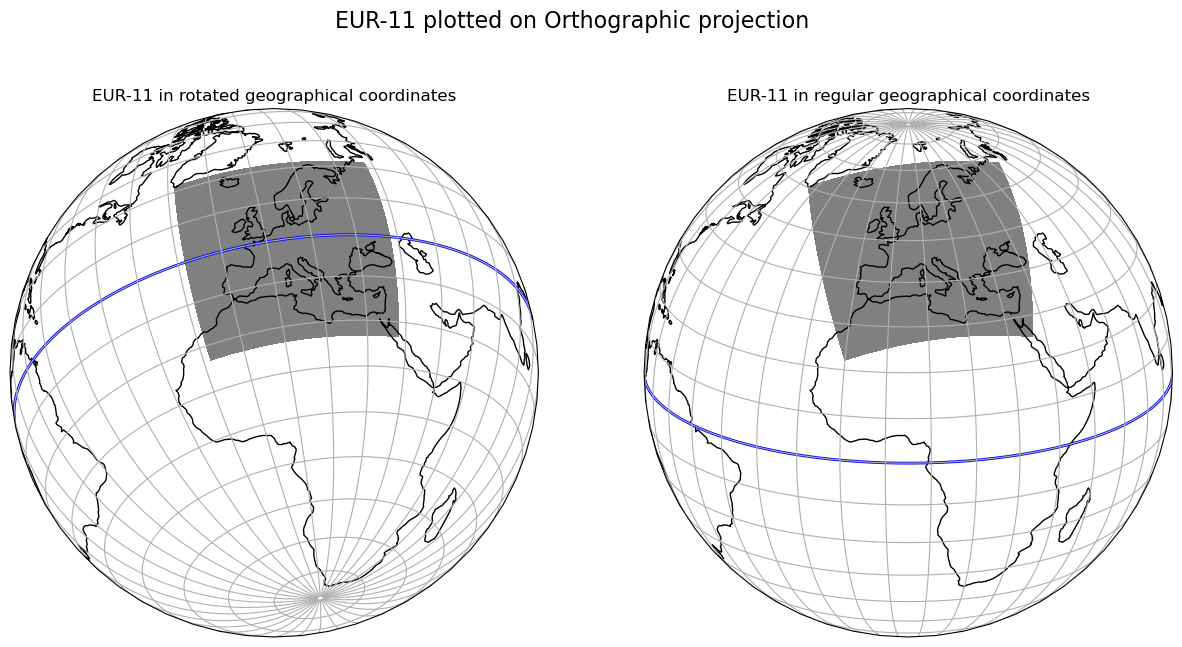

In [7]:
z = np.ones_like(rlon2D)
rotated_pole = cartopy.crs.RotatedPole(pole_latitude=np_lat, pole_longitude=np_lon)
map_projection = cartopy.crs.Orthographic(
    central_longitude=5.0, central_latitude=20.0, globe=None
)

fig = plt.figure(figsize=(15, 7.5))
fig.suptitle("EUR-11 plotted on Orthographic projection", fontsize=16)
plot_globalMapWithData(
    fig=fig,
    map_projection=map_projection,
    coord_projection=rotated_pole,
    title="EUR-11 in rotated geographical coordinates",
    position=121,
    lon2D=rlon2D,
    lat2D=rlat2D,
    data=z,
)
plot_globalMapWithData(
    fig=fig,
    map_projection=map_projection,
    coord_projection=cartopy.crs.PlateCarree(),
    title='EUR-11 in regular geographical coordinates',
    position=122,
    lon2D=lon2D,
    lat2D=lat2D,
    data=z,
)

<GeoAxesSubplot:title={'center':'EUR-11 in regular geographical coordinates'}>

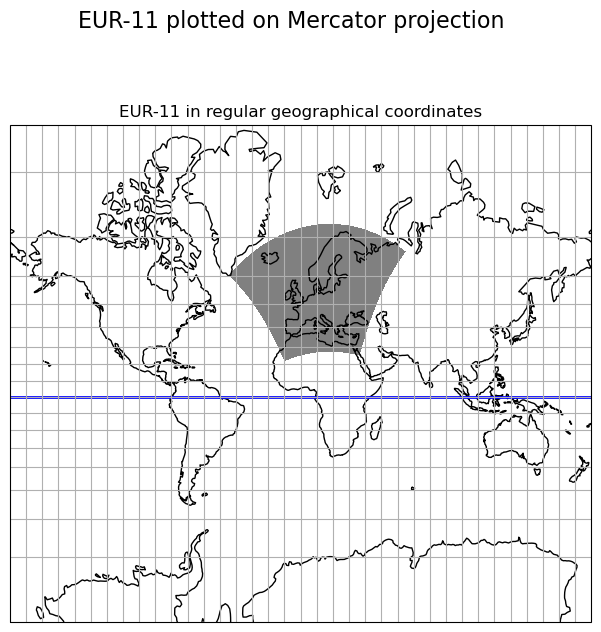

In [8]:
z = np.ones_like(rlon2D)
rotated_pole = cartopy.crs.RotatedPole(pole_latitude=np_lat, pole_longitude=np_lon)
map_projection = cartopy.crs.Mercator(
    central_longitude=0.0,
    min_latitude=-80.0,
    max_latitude=84.0,
    globe=None,
    latitude_true_scale=0.0,
)

fig = plt.figure(figsize=(7.5, 7.5))
fig.suptitle("EUR-11 plotted on Mercator projection", fontsize=16)

plot_globalMapWithData(
    fig=fig,
    map_projection=map_projection,
    coord_projection=cartopy.crs.PlateCarree(),
    title='EUR-11 in regular geographical coordinates',
    position=111,
    lon2D=lon2D,
    lat2D=lat2D,
    data=z,
)

<GeoAxesSubplot:title={'center':'EUR-11 in rotated geographical coordinates'}>

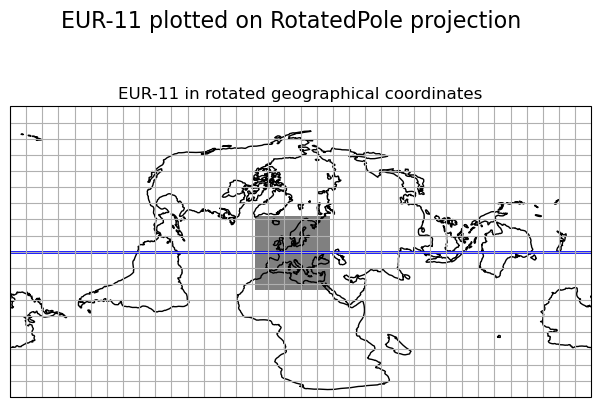

In [9]:
z = np.ones_like(rlon2D)
rotated_pole = cartopy.crs.RotatedPole(pole_latitude=np_lat, pole_longitude=np_lon)
map_projection = cartopy.crs.RotatedPole(pole_latitude=np_lat, pole_longitude=np_lon)

fig = plt.figure(figsize=(7.5, 5))
fig.suptitle("EUR-11 plotted on RotatedPole projection", fontsize=16)
plot_globalMapWithData(
    fig=fig,
    map_projection=map_projection,
    coord_projection=rotated_pole,
    title="EUR-11 in rotated geographical coordinates",
    position=111,
    lon2D=rlon2D,
    lat2D=rlat2D,
    data=z,
)